In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 9.1 MB/s eta 0:00:00


In [4]:
# Import libraries
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, GlobalMaxPooling2D, AveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0, ResNet101
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [5]:

# Define dataset paths
train_dir = '/content/drive/MyDrive/SHSU-Projects/Final_files/KneeOA_Dataset_1_Augmented/Train_Augmented'
val_dir = '/content/drive/MyDrive/SHSU-Projects/Final_files/KneeOA_Dataset_1_Augmented/Val_Augmented'


# Define batch size
batch_size = 20
IMAGE_SIZE = (240, 240)
SEED = 42

# Create datasets using image_dataset_from_directory
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=SEED,
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=True,  # to introduce randomness in each epoch and improve training.
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    seed=SEED,
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False,  # to maintain the original order for consistent evaluation.
)




class_index_to_label = {i: label for i, label in enumerate(train_ds.class_names)}
print('Class index number mapping to class folder names: ',class_index_to_label)

# Apply preprocessing
def preprocess_image(image, label):
#     image = tfa.image.gaussian_filter2d(image, (3, 3), 1.0)
    image = tfa.image.equalize(image)
    return image, label


train_ds = train_ds.map(preprocess_image).shuffle(buffer_size=200)
val_ds = val_ds.map(preprocess_image)


# Optimize data loading (optional)
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)



Found 6972 files belonging to 5 classes.
Found 2495 files belonging to 5 classes.
Class index number mapping to class folder names:  {0: '0', 1: '1', 2: '2', 3: '3', 4: '4'}


In [6]:
base_model = tf.keras.applications.convnext.ConvNeXtBase(weights='imagenet', include_top=False, input_shape=(240, 240, 3))
x = base_model.output
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(612, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(210, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(5, activation='softmax')(x)

for layer in base_model.layers:
    layer.trainable = True

model = tf.keras.Model(inputs=base_model.input, outputs=predictions)


350926856/350926856 [==============================] - 18s 0us/step


List of learning rate:  [6.25e-06, 1.25e-05, 2.5e-05, 5e-05, 0.0001, 9.964234631709187e-05, 9.857450191464337e-05, 9.681174353198687e-05, 9.437928945022771e-05, 9.131193871579975e-05, 8.765357330018056e-05, 8.345653031794292e-05, 7.878085328428369e-05, 7.369343312364993e-05, 6.826705121831976e-05, 6.257933818722543e-05, 5.6711663290882776e-05, 5.074797035076319e-05, 4.477357683661734e-05, 3.887395330218429e-05, 3.3133500630858515e-05, 2.7634342584218365e-05, 2.245515092739488e-05, 1.7670019939210024e-05, 1.3347406408508695e-05]


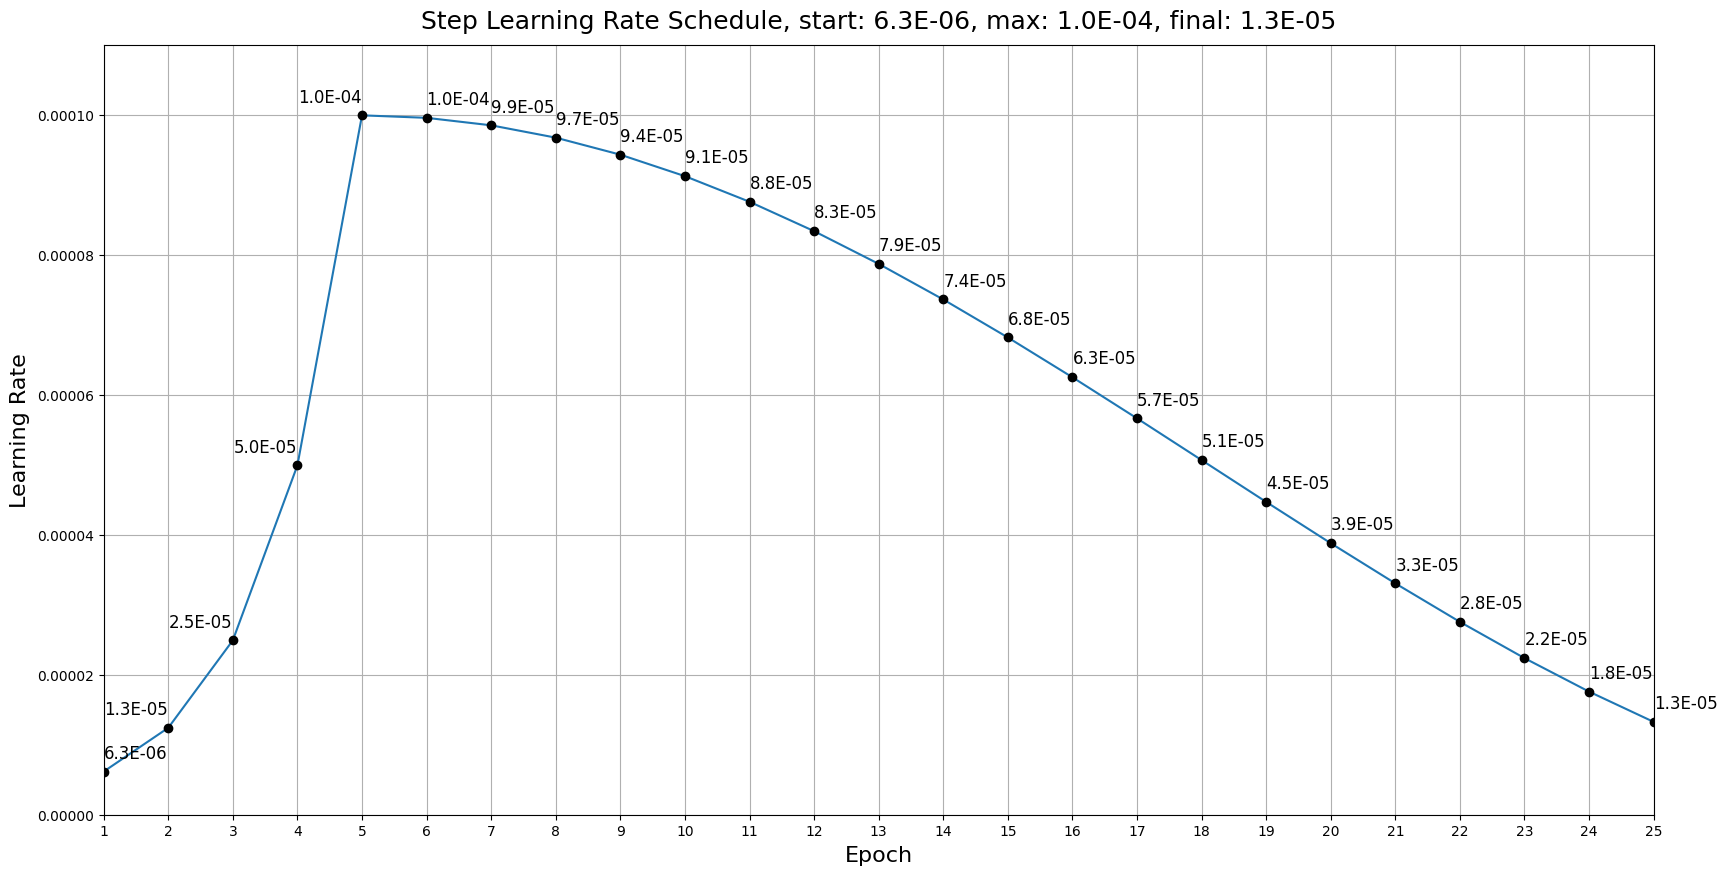

In [12]:
# Import libraries
import math
import sklearn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

N_EPOCHS = 25
warm_up_ep  = 4
num_cycles  = 0.4
lr_max = 1e-4

def learning_rate_fn(current_step, num_warmup_steps, lr_max, num_cycles=0.50, num_training_steps=N_EPOCHS):
    if current_step < num_warmup_steps:
        # exponiancial warmup
        return lr_max * 2 ** -(num_warmup_steps - current_step)
    else:
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr_max


def plot_lr_schedule(lr_schedule, epochs):
    fig = plt.figure(figsize=(20, 10))
    plt.plot([None] + lr_schedule + [None])
    x = np.arange(1, epochs + 1)
    x_axis_labels = [i if epochs <= 40 or i % 5 == 0 or i == 1 else None for i in range(1, epochs + 1)]
    plt.xlim([1, epochs])
    plt.xticks(x, x_axis_labels) # set tick step to 1 and let x axis start at 1

    plt.ylim([0, max(lr_schedule) * 1.1])

    schedule_info = f'start: {lr_schedule[0]:.1E}, max: {max(lr_schedule):.1E}, final: {lr_schedule[-1]:.1E}'
    plt.title(f'Step Learning Rate Schedule, {schedule_info}', size=18, pad=12)

    for x, val in enumerate(lr_schedule):
        if epochs <= 40 or x % 5 == 0 or x is epochs - 1:
            if x < len(lr_schedule) - 1:
                if lr_schedule[x - 1] < val:
                    ha = 'right'
                else:
                    ha = 'left'
            elif x == 0:
                ha = 'right'
            else:
                ha = 'left'
            plt.plot(x + 1, val, 'o', color='black');
            offset_y = (max(lr_schedule) - min(lr_schedule)) * 0.02
            plt.annotate(f'{val:.1E}', xy=(x + 1, val + offset_y), size=12, ha=ha)

    plt.xlabel('Epoch', size=16, labelpad=5)
    plt.ylabel('Learning Rate', size=16, labelpad=5)
    plt.grid()
    plt.show()




LR_SCHEDULE = [learning_rate_fn(step, num_warmup_steps=warm_up_ep, lr_max=lr_max, num_cycles=num_cycles, num_training_steps=N_EPOCHS) for step in range(N_EPOCHS)]
print('List of learning rate: ', LR_SCHEDULE)

plot_lr_schedule(LR_SCHEDULE, epochs=N_EPOCHS)
#lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=0)



In [13]:
LR_SCHEDULE

[6.25e-06,
 1.25e-05,
 2.5e-05,
 5e-05,
 0.0001,
 9.964234631709187e-05,
 9.857450191464337e-05,
 9.681174353198687e-05,
 9.437928945022771e-05,
 9.131193871579975e-05,
 8.765357330018056e-05,
 8.345653031794292e-05,
 7.878085328428369e-05,
 7.369343312364993e-05,
 6.826705121831976e-05,
 6.257933818722543e-05,
 5.6711663290882776e-05,
 5.074797035076319e-05,
 4.477357683661734e-05,
 3.887395330218429e-05,
 3.3133500630858515e-05,
 2.7634342584218365e-05,
 2.245515092739488e-05,
 1.7670019939210024e-05,
 1.3347406408508695e-05]

In [7]:
#lr_list = [ 0.00001, 0.00006, 0.00003, 0.00002, 0.00002, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001 ]


my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/SHSU-Projects/Final_files/Dataset_1_after_augmentation.h5', save_best_only=True),
    #tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True),  # Stop training if no improvement after 3 epochs
    #tf.keras.callbacks.LearningRateScheduler(lambda step: lr_list[step], verbose=0),
    tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=0)
    #tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, min_lr=1e-5, verbose=1)
]



model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=['accuracy']
)


history = model.fit(
    train_ds,
    epochs=25,
    validation_data=val_ds,
    callbacks=[my_callbacks],
)



Epoch 1/25
349/349 [==============================] - ETA: 0s - loss: 4.2722 - accuracy: 0.4102

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


349/349 [==============================] - 873s 1s/step - loss: 4.2722 - accuracy: 0.4102 - val_loss: 1.7455 - val_accuracy: 0.2625 - lr: 0.0010
Epoch 2/25
349/349 [==============================] - 135s 375ms/step - loss: 1.2044 - accuracy: 0.4928 - val_loss: 1.6469 - val_accuracy: 0.4056 - lr: 0.0010
Epoch 3/25
349/349 [==============================] - 121s 335ms/step - loss: 1.1234 - accuracy: 0.5420 - val_loss: 1.7797 - val_accuracy: 0.3283 - lr: 0.0010
Epoch 4/25
349/349 [==============================] - 134s 372ms/step - loss: 1.0758 - accuracy: 0.5516 - val_loss: 1.1776 - val_accuracy: 0.5455 - lr: 0.0010
Epoch 5/25
349/349 [==============================] - 121s 335ms/step - loss: 1.0097 - accuracy: 0.5878 - val_loss: 1.3921 - val_accuracy: 0.4273 - lr: 0.0010
Epoch 6/25
349/349 [==============================] - 121s 335ms/step - loss: 0.9826 - accuracy: 0.6001 - val_loss: 1.3392 - val_accuracy: 0.4798 - lr: 0.0010
Epoch 7/25
349/349 [==============================] - ETA: 0

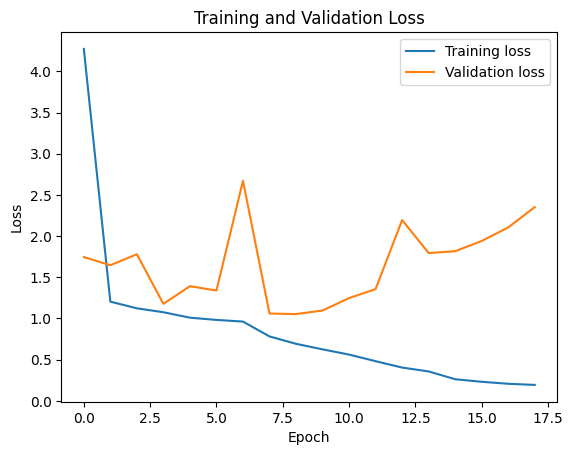

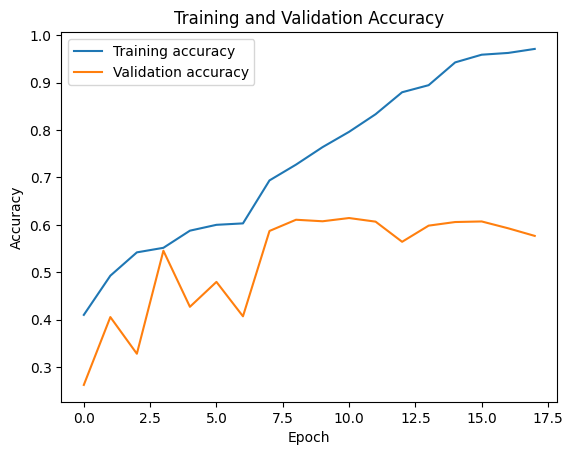

In [8]:
import matplotlib.pyplot as plt

# Plot the training and validation loss curves
plt.plot(model.history.history['loss'], label='Training loss')
plt.plot(model.history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy curves
plt.plot(model.history.history['accuracy'], label='Training accuracy')
plt.plot(model.history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


125/125 [==============================] - 19s 112ms/step


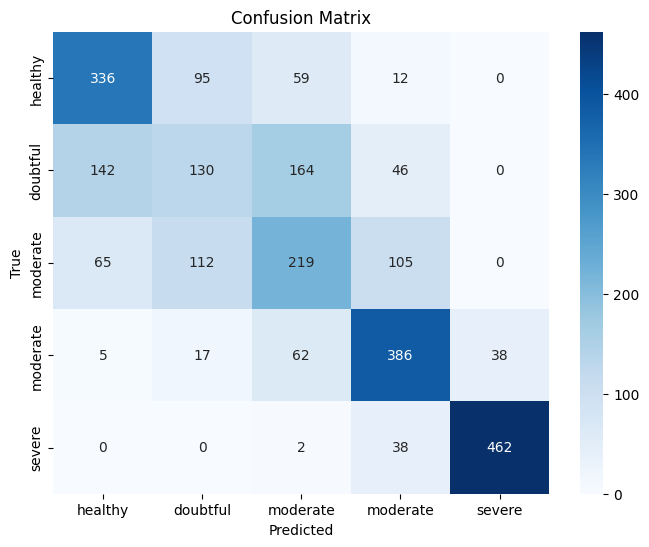

In [9]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


y_pred = model.predict(val_ds)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y.numpy() for x, y in val_ds])
y_true_labels = np.argmax(y_true, axis=1)

# Compute the confusion matrix
confusion = confusion_matrix(y_true_labels, y_pred_labels)

class_names = ['healthy', 'doubtful', 'moderate', 'moderate', 'severe']

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [10]:
from sklearn.metrics import classification_report

print(classification_report(y_true.argmax(1), y_pred.argmax(1), target_names=class_names))

              precision    recall  f1-score   support

     healthy       0.61      0.67      0.64       502
    doubtful       0.37      0.27      0.31       482
    moderate       0.43      0.44      0.43       501
    moderate       0.66      0.76      0.71       508
      severe       0.92      0.92      0.92       502

    accuracy                           0.61      2495
   macro avg       0.60      0.61      0.60      2495
weighted avg       0.60      0.61      0.61      2495

